# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e6/overview

## Imports

In [13]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.compose import ColumnTransformer

from scipy.optimize import minimize

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)
print('LightGBM: ', lgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3
LightGBM:  4.6.0


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

## Choose target and features

In [5]:
target = get_target()

## Encoding

In [6]:
y_train = train_df[target]

## Load XGB OOF

In [7]:
oof_xgb_native = np.load('./OOF/oof_xgb_native.npy')
test_preds_xgb_native = np.load('./OOF/test_preds_xgb_native.npy')

## RidgeCV

In [8]:
X_meta = np.column_stack([oof_xgb_native])

In [9]:
ridge_model = RidgeCV()

In [10]:
ridge_model.fit(X_meta, y_train)

,"alphas alphas: array-like of shape (n_alphas,), default=(0.1, 1.0, 10.0)Array of alpha values to try.Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`.If using Leave-One-Out cross-validation, alphas must be strictly positive.","(0.1, ...)"
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto false, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"scoring scoring: str, callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: negative :ref:`mean squared error ` if cv is None (i.e. when using leave-one-out cross-validation), or :ref:`coefficient of determination ` (:math:`R^2`) otherwise.",None
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the efficient Leave-One-Out cross-validation- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used, else,:class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",None
,"gcv_mode gcv_mode: {'auto', 'svd', 'eigen'}, default='auto'Flag indicating which strategy to use when performingLeave-One-Out Cross-Validation. Options are:: 'auto' : use 'svd' if n_samples > n_features, otherwise use 'eigen' 'svd' : force use of singular value decomposition of X when X is dense, eigenvalue decomposition of X^T.X when X is sparse. 'eigen' : force computation via eigendecomposition of X.X^TThe 'auto' mode is the default and is intended to pick the cheaperoption of the two depending on the shape of the training data.",None
,"store_cv_results store_cv_results: bool, default=FalseFlag indicating if the cross-validation values corresponding toeach alpha should be stored in the ``cv_results_`` attribute (seebelow). This flag is only compatible with ``cv=None`` (i.e. usingLeave-One-Out Cross-Validation)... versionchanged:: 1.5 Parameter name changed from `store_cv_values` to `store_cv_results`.",False
,"alpha_per_target alpha_per_target: bool, default=FalseFlag indicating whether to optimize the alpha value (picked from the`alphas` parameter list) for each target separately (for multi-outputsettings: multiple prediction targets). When set to `True`, afterfitting, the `alpha_` attribute will contain a value for each target.When set to `False`, a single alpha is used for all targets... versionadded:: 0.24",False


In [11]:
print(f"RidgeCV coefficients: ", [f"{i:.3f}" for i in ridge_model.coef_])

RidgeCV coefficients:  ['0.759']


In [18]:
# Predict on the OOF meta-features
stacked_train_preds = ridge_model.predict(X_meta)
stacked_roc = roc_auc_score(y_train, stacked_train_preds)
print(f"Stacked CV ROC: {stacked_roc:.4f}")

Stacked CV ROC: 0.8782


### comparing with ElasticNetCV

In [19]:
from sklearn.linear_model import ElasticNetCV                                                                                                                                                    
elastic = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], cv=5)                                                                                                                                           
elastic.fit(X_meta, y_train)                                                                                                                                                      
print(f"ElasticNet coefs: {elastic.coef_}")

ElasticNet coefs: [ 0.10307644  0.89779759  0.          0.          0.         -0.
 -0.        ]


### trying another RidgeCV stacked on top

In [15]:
ridge_oof = cross_val_predict(RidgeCV(), X_meta, y_train, cv=5)
print(f"Level 1: (RidgeCV) ROC AUC {roc_auc_score(y_train, ridge_oof):.4f}")

Level 1: (RidgeCV) ROC AUC 0.8775


In [16]:
X_level2 = np.column_stack([X_meta, ridge_oof])
print(f"Level 2 features: {X_level2.shape[1]} (was {X_meta.shape[1]})")

Level 2 features: 2 (was 1)


In [19]:
level2_oof = cross_val_predict(RidgeCV(), X_level2, y_train, cv=5)
print(f"Level 2 ROC AUC: {roc_auc_score(y_train, level2_oof):.4f}")

Level 2 ROC AUC: 0.8775


### make final predictions

In [20]:
X_combined_preds = np.column_stack([test_preds_xgb_native])

In [21]:
final_preds = ridge_model.predict(X_combined_preds)

### make final predictions from stacked RidgeCV

In [22]:
ridge_level1 = RidgeCV()
ridge_level1.fit(X_meta, y_train)
train_ridge_preds = ridge_level1.predict(X_meta)
test_ridge_preds = ridge_level1.predict(X_combined_preds)

In [23]:
X_train_level2 = np.column_stack([X_meta, train_ridge_preds])
X_test_level2 = np.column_stack([X_combined_preds, test_ridge_preds])

In [24]:
ridge_level2 = RidgeCV()
ridge_level2.fit(X_train_level2, y_train)
final_preds = ridge_level2.predict(X_test_level2)

## Prepare Submission

In [26]:
# Create submission
submission_df = pd.DataFrame({
  'id': orig_test_df['id'],
  'Heart Disease': final_preds
})

In [29]:
last_submission = pd.read_csv(find_last_submission_file())

if np.allclose(last_submission['Heart Disease'], submission_df['Heart Disease']):
    print("they are the same, don't save")
else:
    submission_df.to_csv(find_next_submission_file(), index=False)
    print(f"saved {find_last_submission_file()}")

saved ./archive/submission_04.csv


## Ensemble Variance Analysis

In [31]:
all_test_preds = np.column_stack([test_preds_xgb_native])

In [32]:
ensemble_variance = np.var(all_test_preds, axis=1)

print(f"Mean variance: {ensemble_variance.mean():.2f}")
print(f"10th percentile: {np.percentile(ensemble_variance, 10):.2f}")

Mean variance: 0.00
10th percentile: 0.00


## OOF Correlation

In [34]:
oof_df = pd.DataFrame({                                                                                                                                                                          
    'xgb_native': oof_xgb_native                                                                                                                            
})

<Axes: >

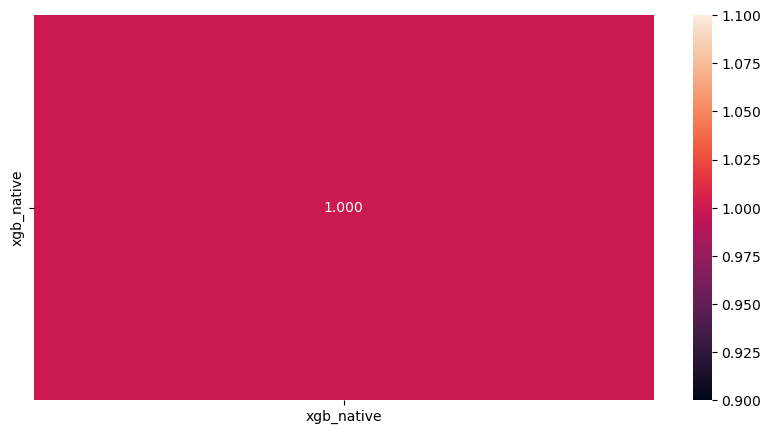

In [35]:
sns.heatmap(oof_df.corr(), annot=True, fmt=".3f")